# Comparing modelled versus observed soil moisture

Started 2023-04-21

modified from LSP notebook. 

This notebooks illustrates relating the CLM-FATES model output to available observational data from the Vestland Climate Grid. We use modelled soil water content and observed soil moisture as an example. The workflow highlights common challenges for comparing ecological observations to LSM/DGVM data. 

General hurdles are...

- ...harmonizing the temporal and spatial scales (aggregated grid cell resolutions (km) vs. local observations (cm-m), decade to century scale simulations vs. few year observational studies, etc.)
- ...different jargon and scientific foci (e.g. variables of interest, species-level studies vs. PFT representation in models, etc.)
- ...data access, documentation, and formats

There are datasets for various ecological experiments in the `Vestland Climate Grid`, for example vegetation removal. This workflow example highly benefits from the VCG data following the [FAIR principles](https://www.go-fair.org/fair-principles/) for data management and stewardship. We can directly access it from the open data management platform [OSF](https://osf.io/) and attain an easily reproducible analysis.

In this notebook, we will...
1. Load model output data
2. Plot the model observations alone
3. Download observational data from OSF
4. Plot the observational data
5. Plot modelled and observed data together

## Specify folders and load VCG data
start by loading necessary libraries:

In [30]:
import xarray as xr  # NetCDF data handling
import matplotlib.pyplot as plt  # Plotting
import json  # For reading data dictionaries stored in json format
import datetime as dt  # for workaround with long simulations (beyond year 2262)
from pathlib import Path
import pandas as pd
import numpy as np

Check the current working directory before modifying paths further down

In [2]:
%%bash
pwd

/mnt/c/Users/evaler/OneDrive - Universitetet i Oslo/Eva/PHD/FATES_INCLINE/src/analysis_and_plotting


Define paths to concatenated output files

In [3]:
# Enter the site code from the LSP
site_code = "ALP4"

# Path to concatenated land archive output
output_data_path = f"../../results/3year_subsets"

# Enter the names of single output files from each simulation, created with the 'combine_model_history_files' notebook.
file_path_DA = f"{output_data_path}/DA.1498-1500.nc"
file_path_DB = f"{output_data_path}/DB.1498-1500.nc"
file_path_IA = f"{output_data_path}/IA.1498-1500.nc"
file_path_IB = f"{output_data_path}/IB.1498-1500.nc"
file_path_IW = f"{output_data_path}/IW.1498-1500.nc"
file_path_IBSP = f"{output_data_path}/IBSP.1498-1500.nc"
file_path_IWSP = f"{output_data_path}/IWSP.1498-1500.nc"

# check that they look correct by printing one
file_path_DA

'../../results/3year_subsets/DA.1498-1500.nc'

Then read in the data

In [4]:
# read in the data with loop:
file_paths = {
    'DA': file_path_DA,
    'DB': file_path_DB,
    'IA': file_path_IA,
    'IB': file_path_IB,
    'IW': file_path_IW,
    'IBSP': file_path_IBSP,
    'IWSP': file_path_IWSP
}

data = {}

for dataset, path in file_paths.items():
    data[dataset] = xr.open_mfdataset(path, 
                                      combine='by_coords', 
                                      decode_times=True)

---
## Modelled soil moisture

The CLM history field `H2OSOI` tracks volumetric soil water (vegetated landunits only) in mm3/mm3 and is the most comparable to the field observations of soil moisture. First, we plot and evaluate the modelled soil moisture alone before comparing to observations.

https://www2.cesm.ucar.edu/models/cesm1.2/clm/models/lnd/clm/doc/UsersGuide/history_fields_table_40.xhtml

Note that the forcing data (GSWP3 or COSMO-REA6) and the observed values cover different time spans. We will not be able to compare the exact same points in time - but it does give us an idea if the model somewhat realistically represents the observed patterns.

The next code cells specify the variable name to look at, converts it from Kelvin to Cescius, and plots the depth levels in the soil column:

In [5]:
# Soil temperature history variable in CLM
CLM_soil_water = "H2OSOI"

In [6]:
# Retrieve soil moisture from model output

# for Default baseline simulation (GSWP3, grass PFTs)
DB_soil_water = data['DB'][CLM_soil_water]
DB_soil_water.attrs["long_name"] = "Volumetric soil water per ground level"
DB_soil_water.attrs["units"] = "mm3/mm3"
DB_soil_water

<xarray.DataArray 'H2OSOI' (time: 36, levsoi: 20, lndgrid: 1)>
dask.array<open_dataset-c06e8154319787fd7b5865fe9cb01728H2OSOI, shape=(36, 20, 1), dtype=float32, chunksize=(36, 20, 1), chunktype=numpy.ndarray>
Coordinates:
  * levsoi   (levsoi) float32 0.01 0.04 0.09 0.16 0.26 ... 5.06 5.95 6.94 8.03
  * time     (time) object 1498-02-01 00:00:00 ... 1501-01-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      Volumetric soil water per ground level
    units:          mm3/mm3
    cell_methods:   time: mean
    landunit_mask:  veg

Investigate the vertical resolution of the included ground levels. See:
https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/tech_note/Ecosystem/CLM50_Tech_Note_Ecosystem.html#id17

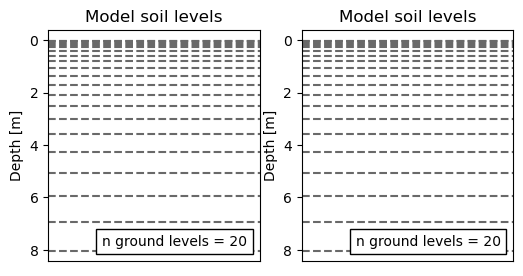

In [15]:
from matplotlib.offsetbox import AnchoredText

# list simulations to include
simulations = ['DB', 'IB']

# Instantiate plot
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(6, 3)
)

for i, simulation in enumerate(simulations):
    ax = axes[i] 
       
    for ground_level in data[simulation][CLM_soil_water].levsoi.values:
        
        ax.axhline(ground_level,
                   color="#696969",
                   linestyle="dashed",
                  )
    # Plot layout
    ax.set_title("Model soil levels")
    ax.set_ylabel("Depth [m]")
    ax.get_xaxis().set_visible(False)
    ax.invert_yaxis()
    
    # Add text box to show number of ground levels
    anchored_text = AnchoredText(f"n ground levels = {len(data[simulation][CLM_soil_water].levsoi.values)}", loc=4)
    ax.add_artist(anchored_text)

plt.show()



Plot the modelled ground temperatures for the top ground levels.

In [32]:
# number of ground levels to plot
max_depth = 5  # in meters
idx_soil_layers = (DB_soil_water.levsoi < max_depth).values.sum() - 1
print("Number of soil levels to plot:", idx_soil_layers)

Number of soil levels to plot: 15


In [42]:
subset = data[simulation][CLM_soil_water].values.reshape(-1)
subset.shape

(720,)

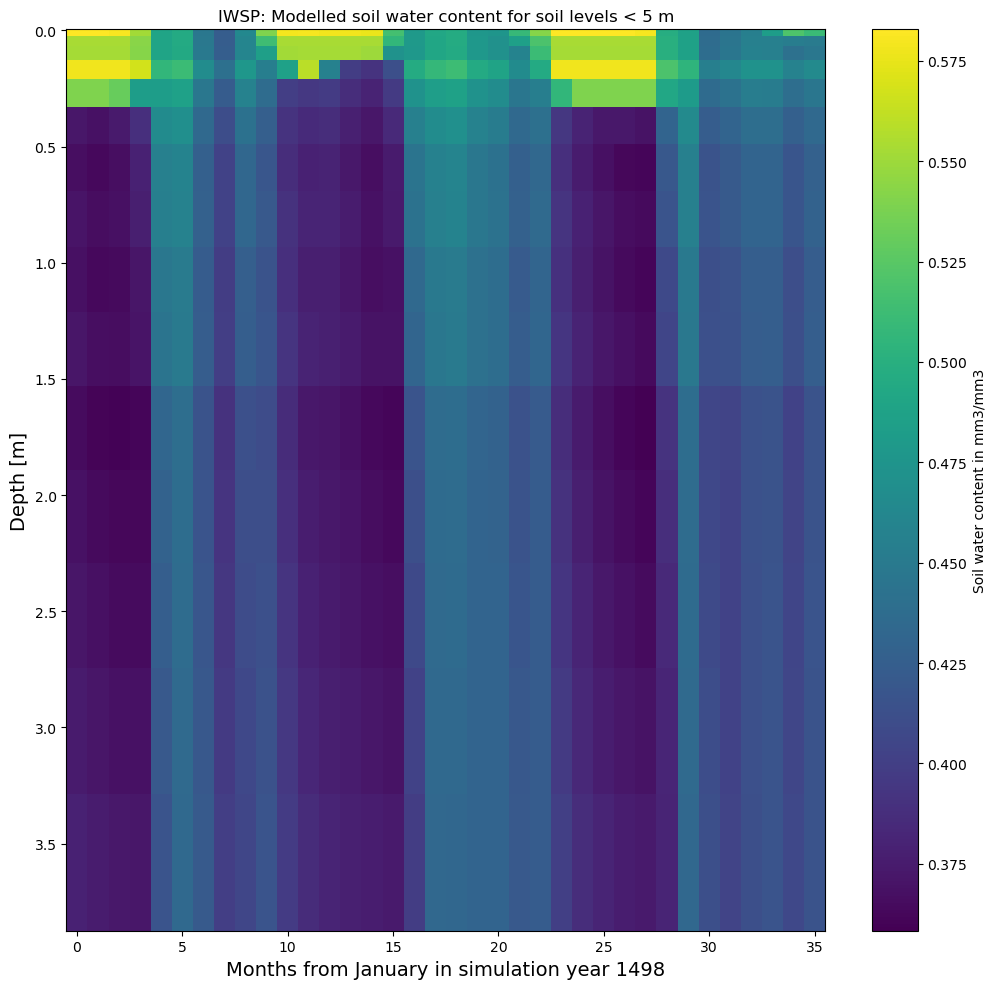

In [49]:
# list simulations to include
simulations = [#'DA', 
               #'DB', 
               #'IA', 
               #'IB', 
               #'IBSP',
               #'IW', 
               'IWSP'
               ]

# Instantiate plot
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(20, 10)
)

# Delete empty axis object if number of simulations in list is odd
if len(axes.flatten()) != len(simulations):
    if len(axes.flatten()) == 2:
        fig.delaxes(axes[-1])
    else:
        fig.delaxes(axes[-1, -1])

# plot 
for i, simulation in enumerate(simulations):
    ax = axes[i] 
    subset = data[simulation][CLM_soil_water]
    subset['time'] = range(len(subset["time"])) # hack around a time format problem
    
    color_bar_plot = subset.isel(levsoi=slice(0, idx_soil_layers)).T.plot(x='time', y='levsoi', ax=ax, #vmin = 0.001, vmax= 0.8,
    cbar_kwargs={
            'label': "Soil water content in mm3/mm3"            
            }
    )
    # Make plot more intuitive by setting depth=0 to the top
    ax.invert_yaxis()
    # Title and labels
    ax.set_title(f"{simulation}: Modelled soil water content for soil levels < 5 m")
    ax.set_ylabel("Depth [m]", fontsize=14)
    ax.set_xlabel("Months from January in simulation year 1498", fontsize=14);

fig.tight_layout()
plt.show()

## Observed soil moisture

Data downloaded from the INCLINE OSF: https://osf.io/zhk3m/ at 2023-01-16. 

Soil moisture was logged with Tomst-loggers, described in Wild et al. 2019, <https://doi.org/10.1016/j.agrformet.2018.12.018>

The measurements are made at about 6 cm depth, and unitless without calibration efforts depending on the soil type.  

Technical description (direct quote from the Wild et al. paper):
"The time-domain transmission method is also used in the TMS logger to measure volumetric soil moisture with a proprietary, patented sensor (patent No. CZ304153). Briefly, high frequency-shaped electromagnetic pulses (ca 2.5 GHz) are sent through a printed circuit ca 30 cm long (Fig. 2); when a pulse reaches the counting unit, another pulse is sent. This occurs within a 640-microsecond time window. Pulses are counted as a raw moisture signal (50–200 MHz). The number of pulses counted is directly related to the soil moisture content, with higher soil moisture reducing the count of pulses received. The counts are then inverted and scaled to the numerical range of 1–4095 (raw TDT data). Typically recorded values range from 100 (ambient air) to 3500 (distilled water). To transform this relative value into volumetric soil moisture, calibration is needed. In Appendix A, we provide calibration curves for basic soil classes, but for more specific soils or more precise transformation, site-specific calibration should be used."

In [50]:
%%bash
pwd

/mnt/c/Users/evaler/OneDrive - Universitetet i Oslo/Eva/PHD/FATES_INCLINE/src/analysis_and_plotting


In [52]:
# Load in data
incline_soil_moisture = pd.read_csv("../../data/VCG/INCLINE_microclimate_soil_moisture.csv")

C:\Users\evaler\AppData\Local\Temp\ipykernel_23980\1984156896.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  incline_soil_moisture = pd.read_csv("../../data/VCG/INCLINE_microclimate_soil_moisture.csv")


In [58]:
# Subset only the ALP4 = Skjellingahaugen site
soil_moisture_obs = incline_soil_moisture[incline_soil_moisture["siteID"] == 'Skjellingahaugen']
soil_moisture_obs.head()

,datetime,loggerID,plotID,siteID,OTC,treatment,comments,soil_moisture
625141,2019-06-21T00:15:00Z,94194624,Skj_4_4,Skjellingahaugen,C,E,NaN,0.345256
625142,2019-06-21T00:30:00Z,94194624,Skj_4_4,Skjellingahaugen,C,E,NaN,0.345483
625143,2019-06-21T00:45:00Z,94194624,Skj_4_4,Skjellingahaugen,C,E,NaN,0.344655
625144,2019-06-21T01:00:00Z,94194624,Skj_4_4,Skjellingahaugen,C,E,NaN,0.344073
625145,2019-06-21T01:15:00Z,94194624,Skj_4_4,Skjellingahaugen,C,E,NaN,0.344073


In [60]:
# Print period for available measurements
print(f"From: {min(soil_moisture_obs['datetime'])}")
print(f"To: {max(soil_moisture_obs['datetime'])}")

From: 2019-06-21T00:15:00Z
To: 2021-09-26T23:45:00Z


Calculate and display monthly and yearly means:

In [61]:
# Next we calculate monthly means
monthly_mean_df = soil_moisture_obs.groupby(
    pd.PeriodIndex(soil_moisture_obs['datetime'], freq='M')
)['soil_moisture'].mean()

# Convert to DataFrame
monthly_mean_df = monthly_mean_df.to_frame()

In [62]:
monthly_mean_df

,soil_moisture
datetime,
2019-06,0.378523
2019-07,0.366638
2019-08,0.349623
2019-09,0.382366
2019-10,0.377886
2019-11,0.319230
2019-12,0.316723
2020-01,0.353127
2020-02,0.305413


In [63]:
# Calculate yearly mean (to enable yearly comparison to model output)
monthly_mean_df['date_dt'] = pd.to_datetime(monthly_mean_df.index.to_timestamp())
monthly_mean_df.groupby(monthly_mean_df.date_dt.dt.year)['soil_moisture'].transform('mean')
monthly_mean_df = monthly_mean_df.reset_index()
# Add integer month column for easier data handling later on
monthly_mean_df['month_int'] = [int(pd.to_datetime(x).strftime('%m')) for x in monthly_mean_df['date_dt'].values]
monthly_mean_df

,datetime,soil_moisture,date_dt,month_int
0,2019-06,0.378523,2019-06-01,6
1,2019-07,0.366638,2019-07-01,7
2,2019-08,0.349623,2019-08-01,8
3,2019-09,0.382366,2019-09-01,9
4,2019-10,0.377886,2019-10-01,10
5,2019-11,0.319230,2019-11-01,11
6,2019-12,0.316723,2019-12-01,12
7,2020-01,0.353127,2020-01-01,1
8,2020-02,0.305413,2020-02-01,2
9,2020-03,0.282296,2020-03-01,3


Then plot the observed data:

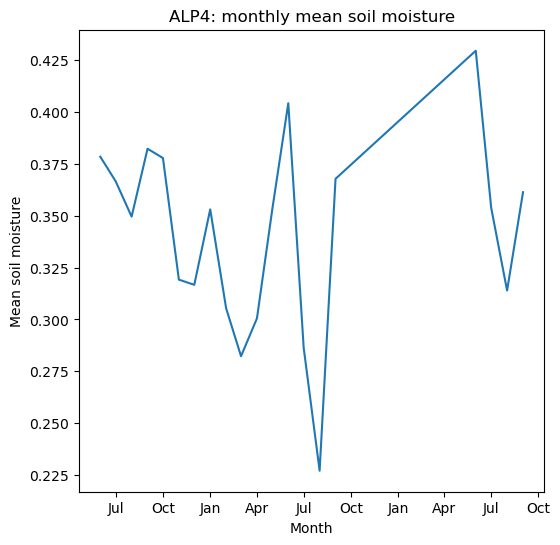

In [65]:
# Plot for quick visualization
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['soil_moisture']
       )
ax.set_title(f"{site_code}: monthly mean soil moisture")
ax.set_xlabel("Month")
ax.set_ylabel("Mean soil moisture")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

## Modelled and observed in one plot

Now we will compare modelled and observed soil moisture, with the full range of the measured data (June 2019 -- Sept 2021) and the last three simulation years. Keep in mind that the forcind data comes from different years, and that the units are not directly comparable. Still, we should be able to say something about variability through the seasons.

### Example plot for one simulation, DB

In [70]:
# Determine maximum and minimum over given period
monthly_modelled_max_soil_moisture_df = \
top_2_layer_soil_moisture.groupby("time.month").max().to_dataframe().reset_index(level=['month', 'lndgrid'])

monthly_modelled_min_soil_moisture_df = \
top_2_layer_soil_moisture.groupby("time.month").min().to_dataframe().reset_index(level=['month', 'lndgrid'])

In [74]:
monthly_mean_df['month_int']

0      6
1      7
2      8
3      9
4     10
5     11
6     12
7      1
8      2
9      3
10     4
11     5
12     6
13     7
14     8
15     9
16     6
17     7
18     8
19     9
Name: month_int, dtype: int64

In [75]:
# Map modelled monthly values to observed monthly values
monthly_mean_df['model_max_of_mean_monthly_soil_moisture'] = None
monthly_mean_df['model_min_of_mean_monthly_soil_moisture'] = None

#for cur_month in monthly_mean_df['month_int']:
for index, cur_month in enumerate(monthly_mean_df['month_int']):
    # Max temperatures
    monthly_mean_df.loc[index, 'model_max_of_mean_monthly_soil_moisture'] = \
        monthly_modelled_max_soil_moisture_df.loc[monthly_modelled_max_soil_moisture_df['month'] == cur_month, 'H2OSOI'].values[0]

    # Min temperatures
    monthly_mean_df.loc[index, 'model_min_of_mean_monthly_soil_moisture'] = \
        monthly_modelled_min_soil_moisture_df.loc[monthly_modelled_min_soil_moisture_df['month'] == cur_month, 'H2OSOI'].values[0]

# Convert datatype from object to float (prevents bug in plotting)
monthly_mean_df['model_max_of_mean_monthly_soil_moisture'] = monthly_mean_df['model_max_of_mean_monthly_soil_moisture'].astype(float)
monthly_mean_df['model_min_of_mean_monthly_soil_moisture'] = monthly_mean_df['model_min_of_mean_monthly_soil_moisture'].astype(float)
monthly_mean_df

,datetime,soil_moisture,date_dt,month_int,model_max_of_mean_monthly_soil_moisture,model_min_of_mean_monthly_soil_moisture
0,2019-06,0.378523,2019-06-01,6,0.454441,0.398362
1,2019-07,0.366638,2019-07-01,7,0.384912,0.361875
2,2019-08,0.349623,2019-08-01,8,0.410865,0.371805
3,2019-09,0.382366,2019-09-01,9,0.481143,0.400644
4,2019-10,0.377886,2019-10-01,10,0.486698,0.463300
5,2019-11,0.319230,2019-11-01,11,0.516705,0.447803
6,2019-12,0.316723,2019-12-01,12,0.540343,0.467287
7,2020-01,0.353127,2020-01-01,1,0.635103,0.439905
8,2020-02,0.305413,2020-02-01,2,0.654674,0.435159
9,2020-03,0.282296,2020-03-01,3,0.652032,0.410423


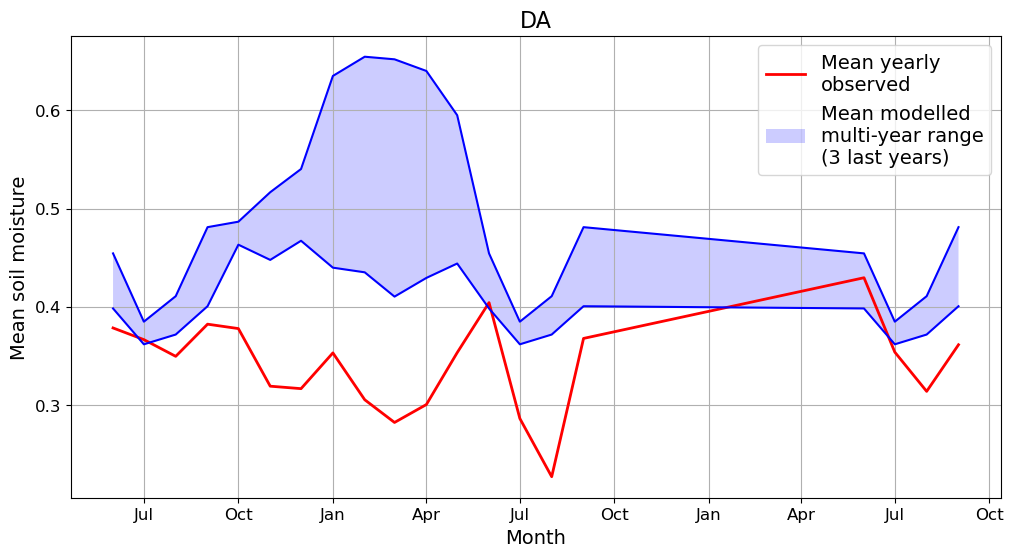

In [77]:
# Create plot
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['soil_moisture'],
        color="red",
        linewidth=2,
        label="Mean yearly\nobserved"
       )

ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['model_max_of_mean_monthly_soil_moisture'],
        color="blue"
       )
ax.plot(monthly_mean_df['date_dt'],
        monthly_mean_df['model_min_of_mean_monthly_soil_moisture'],
        color="blue"
       )


ax.fill_between(monthly_mean_df['date_dt'], 
                monthly_mean_df['model_min_of_mean_monthly_soil_moisture'],
                monthly_mean_df['model_max_of_mean_monthly_soil_moisture'],
                alpha=0.2,
                facecolor="blue",
                label=f"Mean modelled\nmulti-year range\n(3 last years)"
               )

# Plot layout
ax.set_title(f"DA", fontsize=16)
ax.set_ylabel("Mean soil moisture", fontsize=14)
ax.set_xlabel("Month", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax.legend(fontsize=14)
ax.grid()

### The same plot for all simulations

In a loop, repeat the same process to make plots for each simulation.

In [78]:
import matplotlib.dates as mdates

simulations = ['DA', 
               'DB', 
               'IA', 
               'IB', 
               'IBSP',
               'IW', 
               'IWSP'
               ]

# Loop over simulations
for sim in simulations:

    print(sim)

    # Extract data and find monthly average
    # ----------------------------------------------------------------------------------------------
    # Copy the original data
    copy = data[sim][CLM_soil_water].copy()

    # Convert the array of month integers to date strings in 'YYYY-MM' format
    start_year = 1  # Starting year
    end_year = 3  # Ending year
    months = np.arange(1, 13)  # Assuming the array contains values for all 12 months
    time = [f"{year:02d}-{month:02d}" for year in range(start_year, end_year + 1) for month in months]

    # Create a new DataArray with the desired time values
    time_coord = xr.DataArray(pd.to_datetime(time, format='%y-%m'), dims='time')
    copy = copy.assign_coords(time=time_coord)

    # Extract top soil layers (around 10cm), subset last n simulation years defined above, calculate monthly averages (from default 3h model timesteps)
    top_2_layer_soil_temp = copy.isel(
        levsoi=slice(1, 3)
    ).mean(
        dim="levsoi"
    ).resample(time='1M').mean()


    # Determine maximum and minimum temperatures over given period
    # ----------------------------------------------------------------------------------------------
    monthly_modelled_max_soil_moisture_df = \
    top_2_layer_soil_moisture.groupby("time.month").max().to_dataframe().reset_index(level=['month', 'lndgrid'])

    monthly_modelled_min_soil_moisture_df = \
    top_2_layer_soil_moisture.groupby("time.month").min().to_dataframe().reset_index(level=['month', 'lndgrid'])

    # Map modelled monthly values to observed monthly values
    # ----------------------------------------------------------------------------------------------
    monthly_mean_df['model_max_of_mean_monthly_soil_moisture'] = None
    monthly_mean_df['model_min_of_mean_monthly_soil_moisture'] = None

    for index, cur_month in enumerate(monthly_mean_df['month_int']):
        # Max temperatures
        monthly_mean_df.loc[index, 'model_max_of_mean_monthly_soil_moisture'] = \
        monthly_modelled_max_soil_moisture_df.loc[monthly_modelled_max_soil_moisture_df['month'] == cur_month, 'H2OSOI'].values[0]

        # Min temperatures
        monthly_mean_df.loc[index, 'model_min_of_mean_monthly_soil_moisture'] = \
        monthly_modelled_min_soil_moisture_df.loc[monthly_modelled_min_soil_moisture_df['month'] == cur_month, 'H2OSOI'].values[0]

    # Convert datatype from object to float (prevents bug in plotting)
    monthly_mean_df['model_max_of_mean_monthly_soil_moisture'] = monthly_mean_df['model_max_of_mean_monthly_soil_moisture'].astype(float)
    monthly_mean_df['model_min_of_mean_monthly_soil_moisture'] = monthly_mean_df['model_min_of_mean_monthly_soil_moisture'].astype(float)

    # Create plot
    # -------------------------------------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(monthly_mean_df['date_dt'],
            monthly_mean_df['soil_moisture'],
            color="red",
            linewidth=2,
            label="Mean yearly\nobserved"
           )

    ax.plot(monthly_mean_df['date_dt'],
            monthly_mean_df['model_max_of_mean_monthly_soil_moisture'],
            color="blue"
           )
    ax.plot(monthly_mean_df['date_dt'],
            monthly_mean_df['model_min_of_mean_monthly_soil_moisture'],
            color="blue"
           )


    ax.fill_between(monthly_mean_df['date_dt'], 
                    monthly_mean_df['model_min_of_mean_monthly_soil_moisture'],
                    monthly_mean_df['model_max_of_mean_monthly_soil_moisture'],
                    alpha=0.2,
                    facecolor="blue",
                    label=f"Mean modelled\nmulti-year range\n(3 last years)"
                   )

    # Plot layout
    ax.set_title(f"{sim}", fontsize=16)
    ax.set_ylabel("Mean soil moisture", fontsize=14)
    ax.set_xlabel("Month", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

    ax.legend(fontsize=14)
    ax.grid()

    # Save figure
    fig.tight_layout()
    fig.savefig(fname=f"../../results/figures/soil_moisture_vs_obs_{sim}.png", format='png')
    plt.close(fig)

DA
DB
IA
IB
IBSP
IW
IWSP


... something is wrong with this because all the plots were identical regardless of simulation... 